# Use spectra of CTIO Data in January 2017 to do atmospheric studies
==================================================================================================
## Look at equivalent width

- author : Sylvie Dagoret-Campagne
- date   : January 23th 2017

This notebook is supposed to perform an atmospheric properties measurement on spectra

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import pandas as pd

In [101]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [102]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.interpolate import interp1d

In [103]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [104]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [105]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [106]:
from IPython.display import Image, display

In [107]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [108]:
from scipy.interpolate import interp1d

In [109]:
import datetime
from dateutil import parser  # very usefull time format smart parser

In [110]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [111]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [112]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')

In [113]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [114]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [115]:
inputdir="./spectrum_calibcompsimrealspec"
object_name='HD14943'

In [116]:
outputdir="./spectrum_ana"

In [117]:
ensure_dir(outputdir)

In [118]:
output_file='AnaEqWdtFromSpectra_'+object_name+'.csv'

## Location of calibrated spectra and Simulations
----------------------------------

In [119]:
input_filelist=os.listdir(inputdir) 

In [120]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [121]:
print input_filelist[0:5]

['compSimRealSpectra_HD14943_20170118_248.fits'
 'compSimRealSpectra_HD14943_20170118_250.fits'
 'compSimRealSpectra_HD14943_20170118_252.fits'
 'compSimRealSpectra_HD14943_20170118_254.fits']


In [122]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [123]:
re.findall('^compSimRealSpectra_HD14943_20170118_([0-9]+).fits',input_filelist[0])

['248']

In [124]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list


    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter                           
                num_str=re.findall('^compSimRealSpectra_HD14943_20170118_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [125]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [126]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [127]:
print indexes_files

[248 250 252 254]


In [128]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [129]:
sorted_numbers=indexes_files[sorted_indexes]

In [130]:
print sorted_numbers

[248 250 252 254]


In [131]:
print sorted_indexes

[0 1 2 3]


In [132]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [133]:
sorted_files[0:5]

array([ './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170118_248.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170118_250.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170118_252.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170118_254.fits'], 
      dtype='|S76')

## Build full filename
----------------------------

In [134]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [135]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [136]:
print sorted_filenames.shape

(4,)


## Acces to spectrum data
----------------------------------

In [137]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [138]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra_data = []
    all_rightspectra_data = []
    all_leftspectra_sim = []
    all_rightspectra_sim = []
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
    
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum_data=table_data.field('CalibLeftSpecData')
        left_spectrum_sim=table_data.field('CalibLeftSpecSim')
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum_data=table_data.field('CalibRightSpecData')
        right_spectrum_sim=table_data.field('CalibRightSpecSim')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra_data.append(left_spectrum_data)
        all_rightspectra_data.append(right_spectrum_data)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
        all_leftspectra_sim.append(left_spectrum_sim)
        all_rightspectra_sim.append(right_spectrum_sim)
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl, \
        all_rightspectra_wl

In [139]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl,all_rightspectra_wl=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

In [140]:
print len(all_dates)

4


## Show Spectra
-----------------------

In [141]:
NDATA=len(all_rightspectra_data)

In [142]:
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

In [143]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
def ShowSpectra(all_spectra,all_ssim,all_wl,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/4)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(25,20))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%4
        iy=index/4
        spectrum=all_spectra[index]
        spectrumsim=all_ssim[index]
        wl=all_wl[index]
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2,label='data')
        axarr[iy,ix].plot(wl,spectrumsim,'b-',lw=2,label='sim')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,3000.)
        axarr[iy,ix].set_xlim(0.,1000.)
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
      
        
    
    #title='spectra'
    #plt.suptitle(title,size=16)
   

### Work only on right spectra

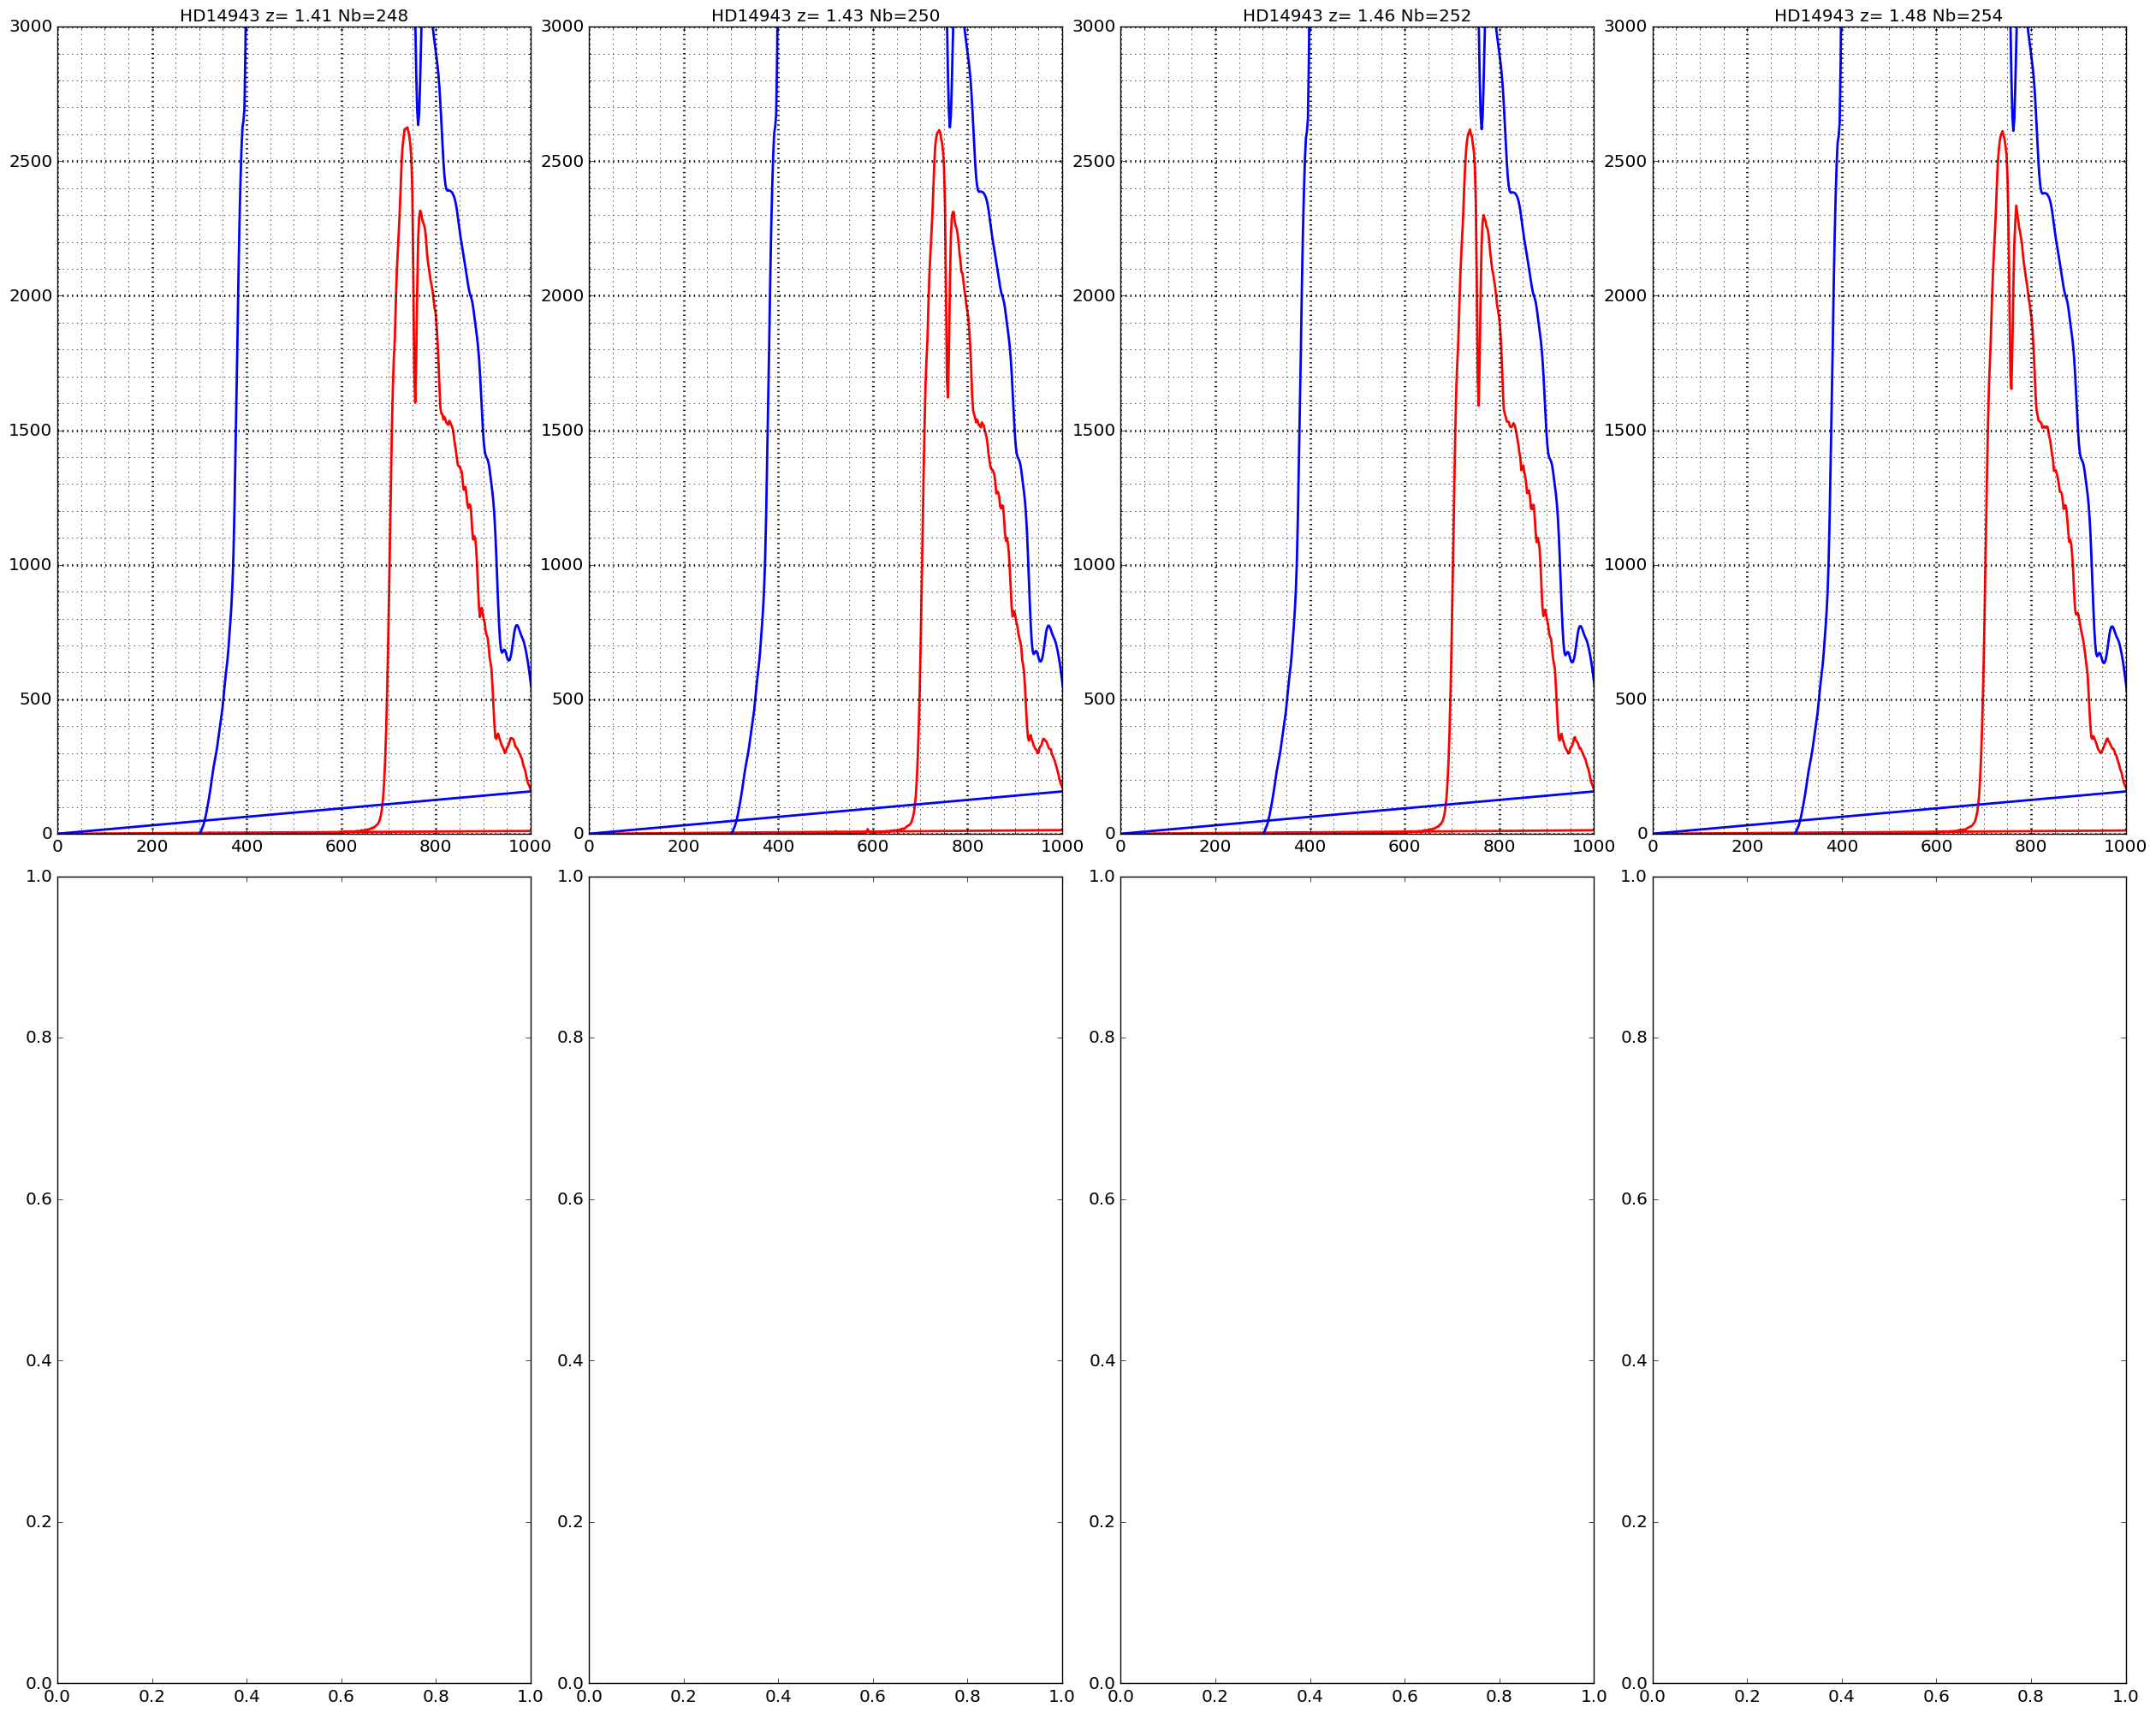

In [144]:
ShowSpectra(all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name)

In [145]:
wl_O2Aline=759.37      # Balmer Lines
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175
wl_Heline=397.0

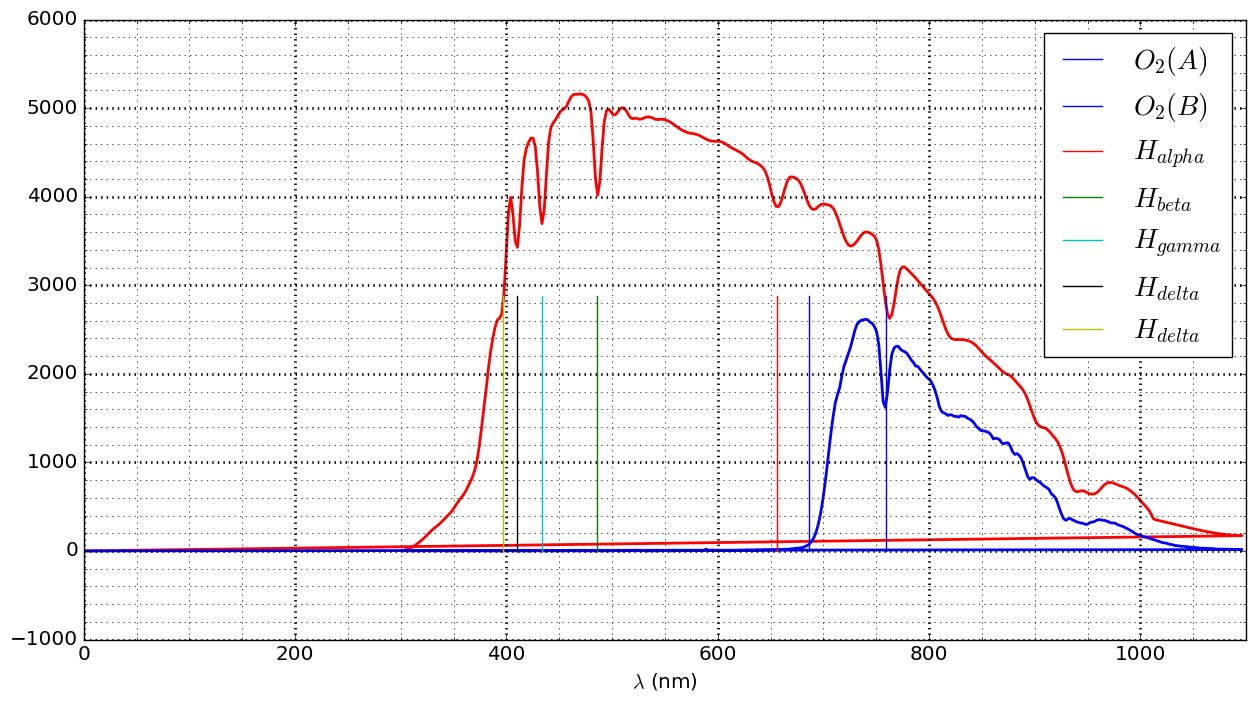

In [146]:
sel=1
thespectrum=all_rightspectra_data[sel]
thesimspectrum=all_rightspectra_sim[sel]

thewl=all_rightspectra_wl[sel]
ymin=thespectrum.min()
ymax=thespectrum.max()*1.1

fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.plot(thewl,thesimspectrum,'r-',lw=2)
ax.plot(thewl,thespectrum,'b-',lw=2)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y-',label='$H_{delta}$',lw=1)

ax.legend(loc='best',fontsize=20)
ax.set_xlim(0,1100)
ax.set_xlabel("$\lambda$ (nm)")

## Measurement of Equivalent Width
==============================================

In [147]:
def ShowEquivalentWidth(wl,spec,wl1,wl2,wl3,wl4):
    """
    ShowEquivalentWidth : show how the equivalent width must be computed
    """
    selected_indexes=np.where(np.logical_and(wl>=wl1,wl<=wl4))
        
    wl_cut=wl[selected_indexes]
    spec_cut=spec[selected_indexes]
    ymin=spec_cut.min()
    ymax=spec_cut.max()
    
    plt.figure()
    plt.plot(wl_cut,spec_cut)
    plt.plot([wl2,wl2],[ymin,ymax],'r-.',lw=2)
    plt.plot([wl3,wl3],[ymin,ymax],'r-.',lw=2)
    
    
    # continuum fit
    continuum_indexes=np.where(np.logical_or(np.logical_and(wl>=wl1,wl<=wl2),np.logical_and(wl>=wl3,wl<wl4)))
    x_cont=wl[continuum_indexes]
    y_cont=spec[continuum_indexes]
    z_cont_fit=np.polyfit(x_cont, y_cont,1)
        
    pol_cont_fit=np.poly1d(z_cont_fit)
    
    fit_line_x=np.linspace(wl1,wl4,50)
    fit_line_y=pol_cont_fit(fit_line_x)
    
    plt.plot(x_cont,y_cont,'o')
    
    plt.plot(fit_line_x,fit_line_y,'g--',lw=1)
    
    plt.grid(True)
    plt.title('Equivalent width computation')
    
    # compute the ratio spectrum/continuum
    full_continum=pol_cont_fit(wl_cut)    
    ratio=spec_cut/full_continum
    
    plt.figure()
    plt.plot(wl_cut,ratio)
    plt.plot([wl2,wl2],[0,1.2],'r-.',lw=2)
    plt.plot([wl3,wl3],[0,1.2],'r-.',lw=2)
    plt.grid(True)
    
    
    NBBins=len(wl_cut)
    wl_shift_right=np.roll(wl_cut,1)
    wl_shift_left=np.roll(wl_cut,-1)
    wl_bin_size=(wl_shift_left-wl_shift_right)/2. # size of each bin

    
    outside_band_indexes=np.where(np.logical_or(wl_cut<wl2,wl_cut>wl3))
    wl_bin_size[outside_band_indexes]=0  # erase bin width outside the band
                       
    # calculation of equivalent width
    
    absorption_band=wl_bin_size*(1-ratio)
    equivalent_width= absorption_band.sum()
    
    
    return equivalent_width

In [148]:
def ComputeEquivalentWidth(wl,spec,wl1,wl2,wl3,wl4):
    """
    ComputeEquivalentWidth : compute the equivalent width must be computed
    """
    selected_indexes=np.where(np.logical_and(wl>=wl1,wl<=wl4))
        
    wl_cut=wl[selected_indexes]
    spec_cut=spec[selected_indexes]
    ymin=spec_cut.min()
    ymax=spec_cut.max()
     
    # continuum fit
    continuum_indexes=np.where(np.logical_or(np.logical_and(wl>=wl1,wl<=wl2),np.logical_and(wl>=wl3,wl<wl4)))
    x_cont=wl[continuum_indexes]
    y_cont=spec[continuum_indexes]
    z_cont_fit=np.polyfit(x_cont, y_cont,1)
        
    pol_cont_fit=np.poly1d(z_cont_fit)
    
    fit_line_x=np.linspace(wl1,wl4,50)
    fit_line_y=pol_cont_fit(fit_line_x)
    
    
    # compute the ratio spectrum/continuum
    full_continum=pol_cont_fit(wl_cut)    
    ratio=spec_cut/full_continum
    

    # compute bin size in the band
    wl_shift_right=np.roll(wl_cut,1)
    wl_shift_left=np.roll(wl_cut,-1)
    wl_bin_size=(wl_shift_left-wl_shift_right)/2. # size of each bin    
    outside_band_indexes=np.where(np.logical_or(wl_cut<wl2,wl_cut>wl3))
    wl_bin_size[outside_band_indexes]=0  # erase bin width outside the band
                                  
    
    # calculation of equivalent width    
    absorption_band=wl_bin_size*(1-ratio)
    equivalent_width= absorption_band.sum()    
    
    return equivalent_width

In [149]:
def ShowEquivalentWidth2(wl,spec,wl1,wl2,wl3,wl4,label='absortion line'):
    """
    ShowEquivalentWidth : show how the equivalent width must be computed
    """
    
    f, axarr = plt.subplots(1,2,figsize=(9,3))
    
    
    ## Figure 1
    ##------------
    selected_indexes=np.where(np.logical_and(wl>=wl1,wl<=wl4))
        
    wl_cut=wl[selected_indexes]
    spec_cut=spec[selected_indexes]
    ymin=spec_cut.min()
    ymax=spec_cut.max()
    
    axarr[0].plot(wl_cut,spec_cut)
    axarr[0].plot([wl2,wl2],[ymin,ymax],'r-.',lw=2)
    axarr[0].plot([wl3,wl3],[ymin,ymax],'r-.',lw=2)
    
    # continuum fit
    continuum_indexes=np.where(np.logical_or(np.logical_and(wl>=wl1,wl<=wl2),np.logical_and(wl>=wl3,wl<wl4)))
    x_cont=wl[continuum_indexes]
    y_cont=spec[continuum_indexes]
    z_cont_fit=np.polyfit(x_cont, y_cont,1)
        
    pol_cont_fit=np.poly1d(z_cont_fit)
    
    fit_line_x=np.linspace(wl1,wl4,50)
    fit_line_y=pol_cont_fit(fit_line_x)
    
    
    axarr[0].plot(x_cont,y_cont,'o')
    axarr[0].plot(fit_line_x,fit_line_y,'g--',lw=1)
    
    axarr[0].grid(True)
    axarr[0].set_xlabel('$\lambda$ (nm)')
    
    # compute the ratio spectrum/continuum
    full_continum=pol_cont_fit(wl_cut)    
    ratio=spec_cut/full_continum
    
    # Figure 2
    #-----------
    axarr[1].plot(wl_cut,ratio)
    axarr[1].plot([wl2,wl2],[0,1.2],'r-.',lw=2)
    axarr[1].plot([wl3,wl3],[0,1.2],'r-.',lw=2)
    axarr[1].grid(True)
    
    axarr[1].set_xlabel('$\lambda$ (nm)')
    
    NBBins=len(wl_cut)
    wl_shift_right=np.roll(wl_cut,1)
    wl_shift_left=np.roll(wl_cut,-1)
    wl_bin_size=(wl_shift_left-wl_shift_right)/2. # size of each bin

    
    outside_band_indexes=np.where(np.logical_or(wl_cut<wl2,wl_cut>wl3))
    wl_bin_size[outside_band_indexes]=0  # erase bin width outside the band
                       
    # calculation of equivalent width
    
    absorption_band=wl_bin_size*(1-ratio)
    equivalent_width= absorption_band.sum()
    
    
    title = 'Equivalent width computation for {}'.format(label)
    f.suptitle(title)
    
    return equivalent_width

In [150]:
print ComputeEquivalentWidth(thewl,thespectrum,732,744,770,790)

2.64146


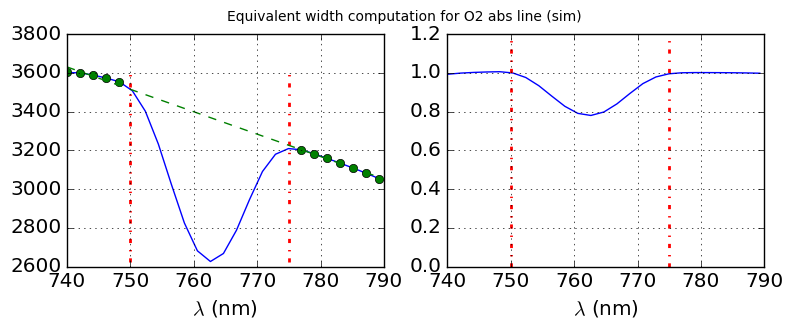

In [151]:
EQW = ShowEquivalentWidth2(thewl,thesimspectrum,740,750,775,790,'O2 abs line (sim)')

## A) O2 absorption line
==============================

In [152]:
#EQW = ShowEquivalentWidth(thewl,thespectrum,732,744,770,790)
EQW_DATA_O2 = ComputeEquivalentWidth(thewl,thespectrum,732,744,770,790)

In [153]:
#EQW = ShowEquivalentWidth(thewl,thesimspectrum,740,750,775,790)
EQW_SIM_O2 = ComputeEquivalentWidth(thewl,thesimspectrum,740,750,775,790)

In [154]:
print ' EQW_SIM(O2) = ',EQW_SIM_O2, 'ns'

 EQW_SIM(O2) =  2.81139 ns


In [155]:
print ' EQW_DATA(O2) = ',EQW_DATA_O2, 'ns'

 EQW_DATA(O2) =  2.64146 ns


In [156]:
WL1_O2_DATA=742   
WL2_O2_DATA=744
WL3_O2_DATA=770
WL4_O2_DATA=790

In [157]:
WL1_O2_SIM=745  
WL2_O2_SIM=750
WL3_O2_SIM=775
WL4_O2_SIM=790

In [158]:
def ShowAllEquivalentWidth(all_wl,all_spec,wl1,wl2,wl3,wl4,label='absorption line'):
        
    NBSPECTRA=len(all_spec)
    
    for index in np.arange(0,NBSPECTRA):        
        spectrum=all_spec[index]
        wl=all_wl[index]
        
        newlabel = label+ ' for image {}'.format(sorted_numbers[index]) 
        
        ShowEquivalentWidth2(wl,spectrum,wl1,wl2,wl3,wl4,label=newlabel)


In [159]:
def ComputeAllEquivalentWidth(all_wl,all_spec,wl1,wl2,wl3,wl4):
    
    EQW_coll = []
    
    NBSPECTRA=len(all_spec)
    
    for index in np.arange(0,NBSPECTRA):        
        spectrum=all_spec[index]
        wl=all_wl[index]
        eqw=ComputeEquivalentWidth(wl,spectrum,wl1,wl2,wl3,wl4)
        EQW_coll.append(eqw)
        
    return EQW_coll

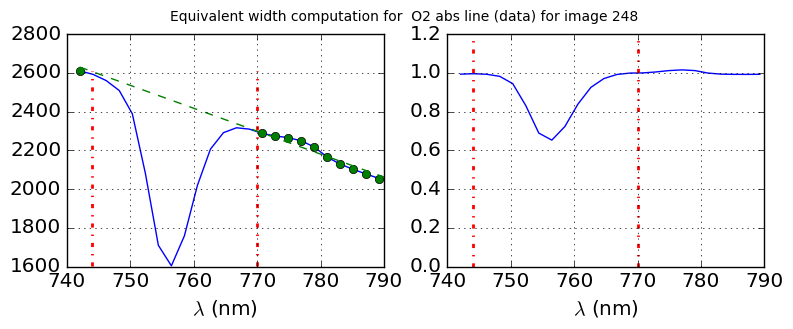

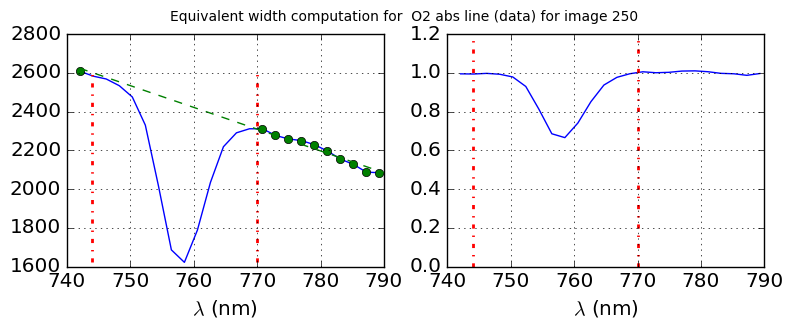

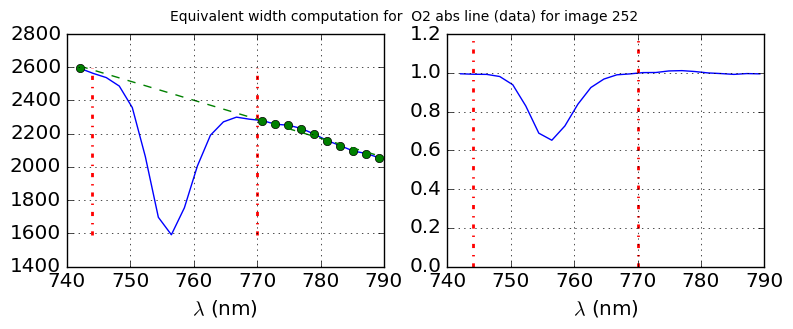

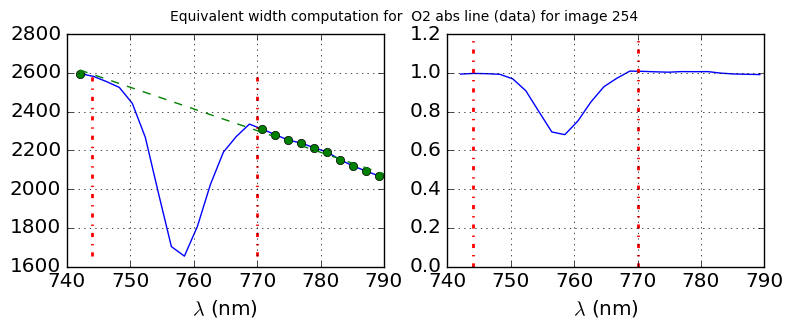

In [160]:
ShowAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_data,WL1_O2_DATA,WL2_O2_DATA,WL3_O2_DATA,WL4_O2_DATA,' O2 abs line (data)')

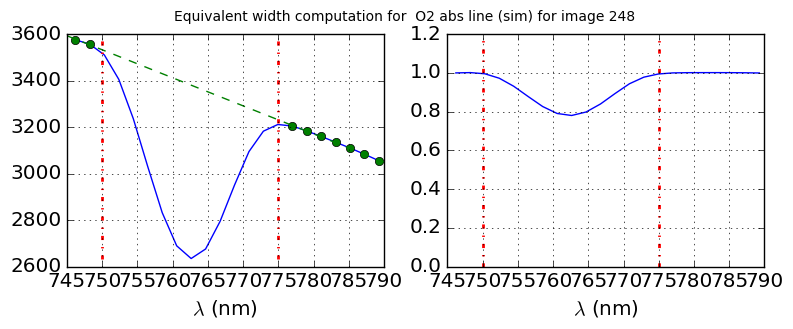

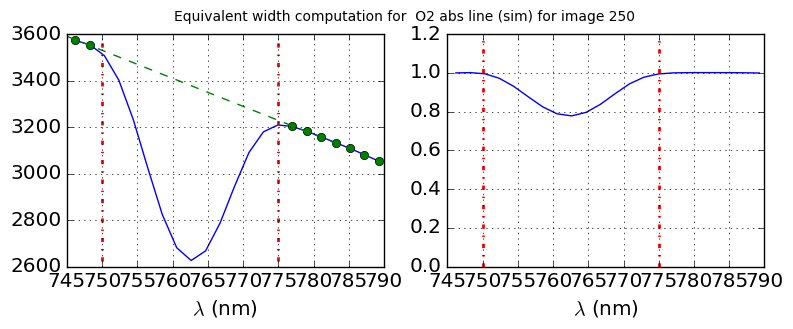

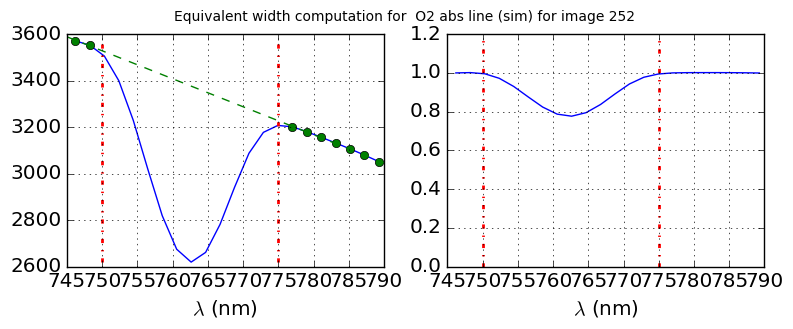

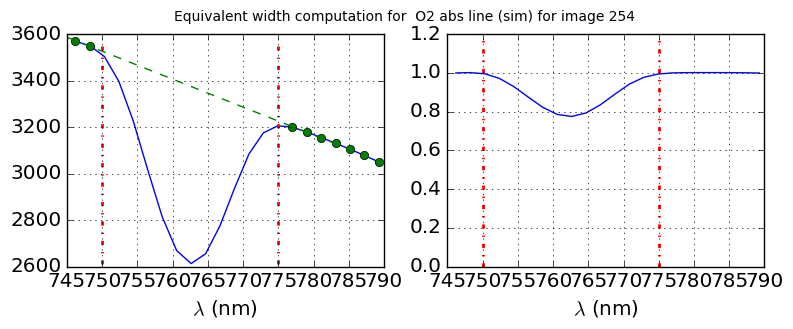

In [161]:
ShowAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_sim,WL1_O2_SIM,WL2_O2_SIM,WL3_O2_SIM,WL4_O2_SIM,' O2 abs line (sim)')

In [162]:
All_eqw_O2_Data=ComputeAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_data,WL1_O2_DATA,WL2_O2_DATA,WL3_O2_DATA,WL4_O2_DATA)

In [163]:
All_eqw_O2_Sim=ComputeAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_sim,WL1_O2_SIM,WL2_O2_SIM,WL3_O2_SIM,WL4_O2_SIM)

In [164]:
am=np.array(all_airmass)

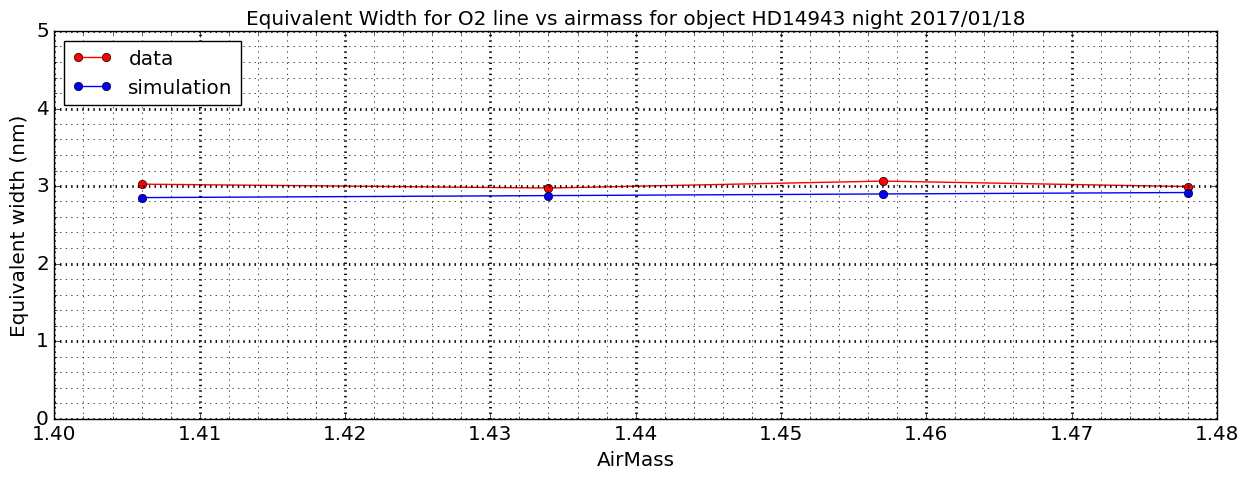

In [165]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)

ax.plot(am, All_eqw_O2_Data,marker='o',color='red',lw=1,label='data')
ax.plot(am, All_eqw_O2_Sim,marker='o',color='blue',lw=1,label='simulation')

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())   
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.set_ylabel('Equivalent width (nm)')
ax.set_xlabel('AirMass')

ax.set_ylim(0.,5.)

title='Equivalent Width for O2 line vs airmass for object {} night 2017/01/18'.format(object_name)

plt.title(title)
plt.legend(loc=2)

#plt.savefig(figfilename1, bbox_inches='tight')

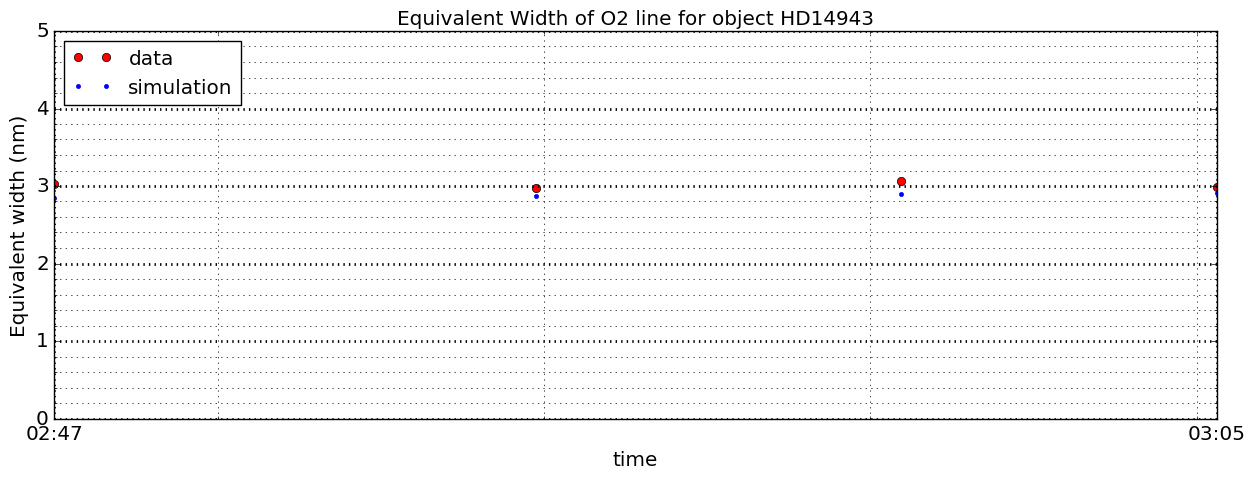

In [166]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, All_eqw_O2_Data,marker='o',color='red',lw=0,label='data',linewidth=3)
ax.plot_date(all_dt, All_eqw_O2_Sim,marker='.',color='blue',lw=0,label='simulation',linewidth=3)
#ax.plot_date(all_dt, am,marker='+',color='black',label='airmass',linewidth=3)
#ax.set_ylim(0,1.2)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('Equivalent width (nm)')
ax.set_xlabel('time')
ax.set_ylim(0.,5.)

title='Equivalent Width of O2 line for object {}'.format(object_name)

plt.title(title)
plt.legend(loc=2)

#plt.savefig(figfilename1, bbox_inches='tight')

## B) H2O absorption line
================================

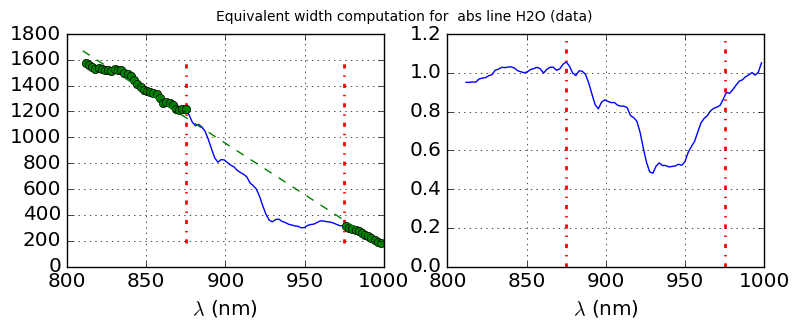

In [167]:
EQW_H2O_DATA = ShowEquivalentWidth2(thewl,thespectrum,810,875,975,1000,' abs line H2O (data)')

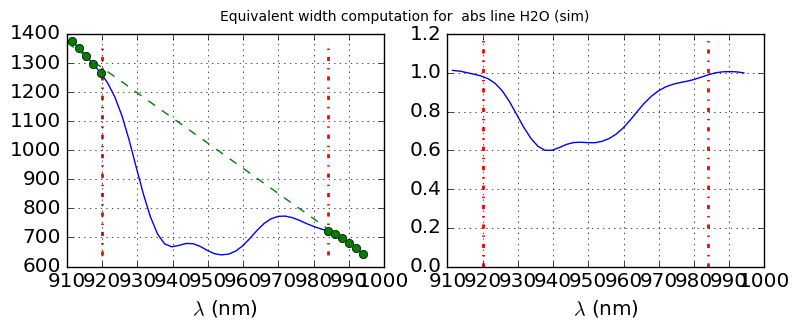

In [168]:
EQW_H2O_SIM = ShowEquivalentWidth2(thewl,thesimspectrum,910,920,984,995,' abs line H2O (sim)')

In [169]:
print EQW_H2O_DATA,' ' ,EQW_H2O_SIM

25.4887   13.9849


In [170]:
#EQW_H2O_DATA = ShowEquivalentWidth2(thewl,thespectrum,810,875,970,1000,' abs line H2O (data)')
WL1_H2O_DATA=810
WL2_H2O_DATA=875
WL3_H2O_DATA=975
WL4_H2O_DATA=1000

In [171]:
#EQW_H2O_SIM = ShowEquivalentWidth2(thewl,thesimspectrum,910,920,984,995,' abs line H2O (sim)')
WL1_H2O_SIM=910
WL2_H2O_SIM=920
WL3_H2O_SIM=984
WL4_H2O_SIM=995

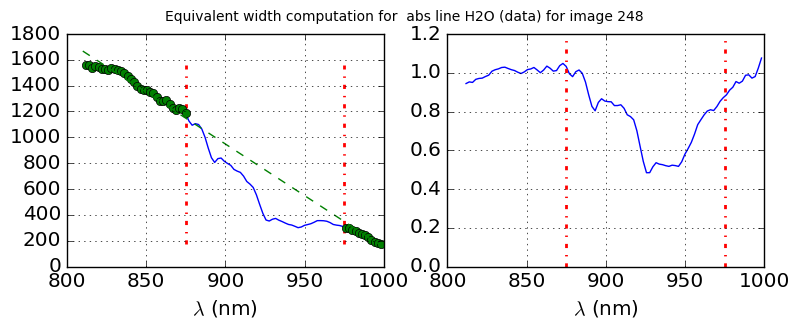

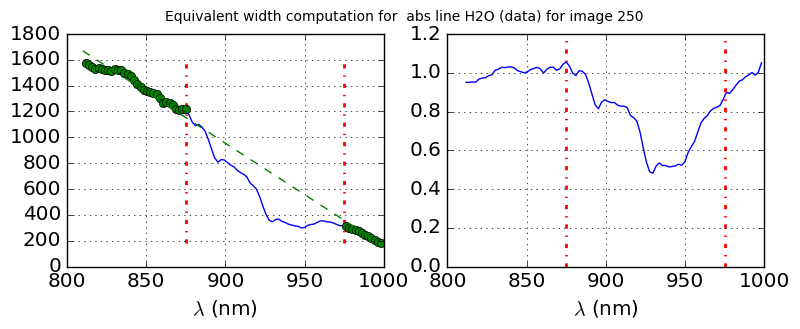

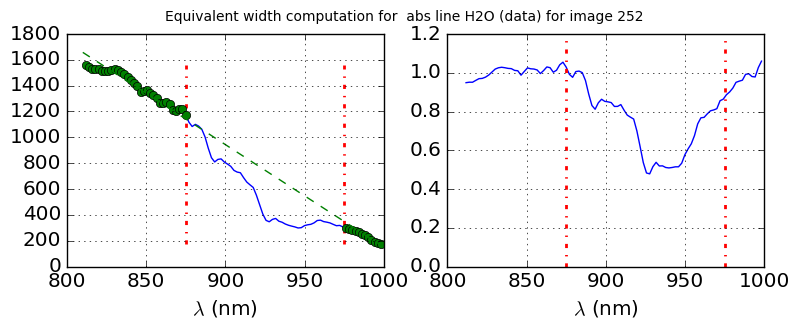

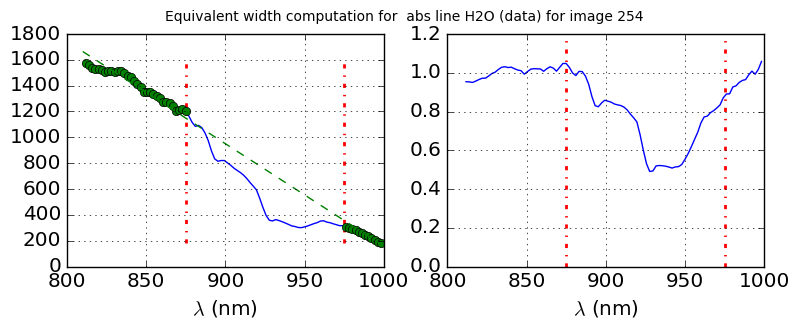

In [172]:
ShowAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_data,WL1_H2O_DATA,WL2_H2O_DATA,WL3_H2O_DATA,WL4_H2O_DATA, ' abs line H2O (data)')

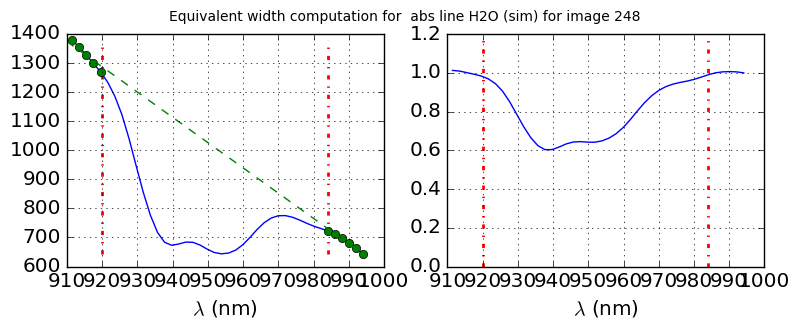

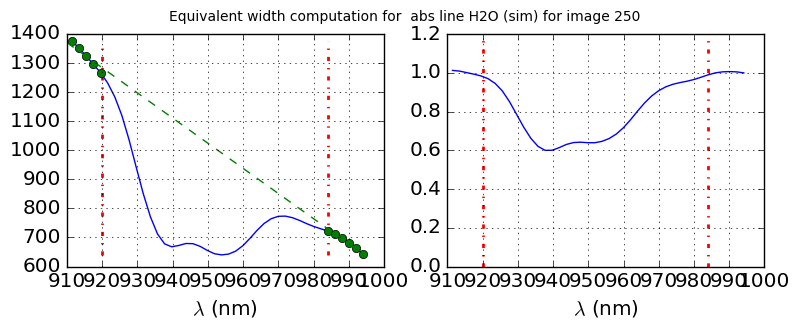

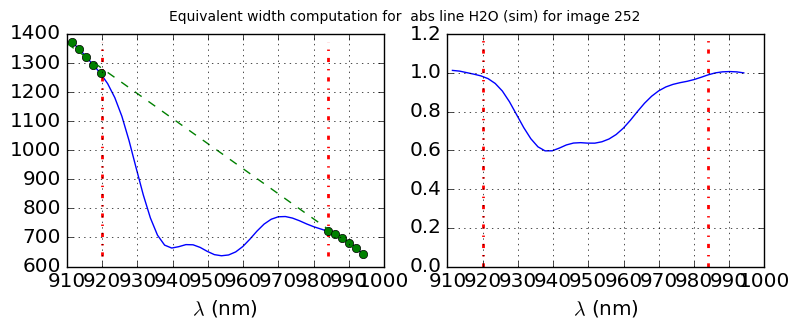

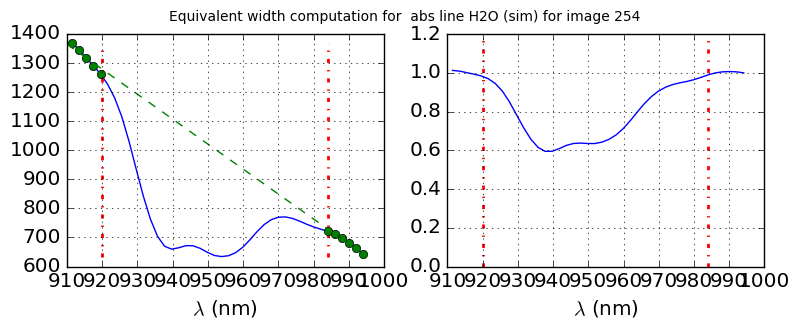

In [173]:
ShowAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_sim,WL1_H2O_SIM,WL2_H2O_SIM,WL3_H2O_SIM,WL4_H2O_SIM, ' abs line H2O (sim)')

In [174]:
All_eqw_H2O_Data=ComputeAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_data,WL1_H2O_DATA,WL2_H2O_DATA,WL3_H2O_DATA,WL4_H2O_DATA)

In [175]:
All_eqw_H2O_Sim=ComputeAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_sim,WL1_H2O_SIM,WL2_H2O_SIM,WL3_H2O_SIM,WL4_H2O_SIM)

In [176]:
All_eqw_H2O_Data

[25.905228, 25.488676, 26.178799, 25.699078]

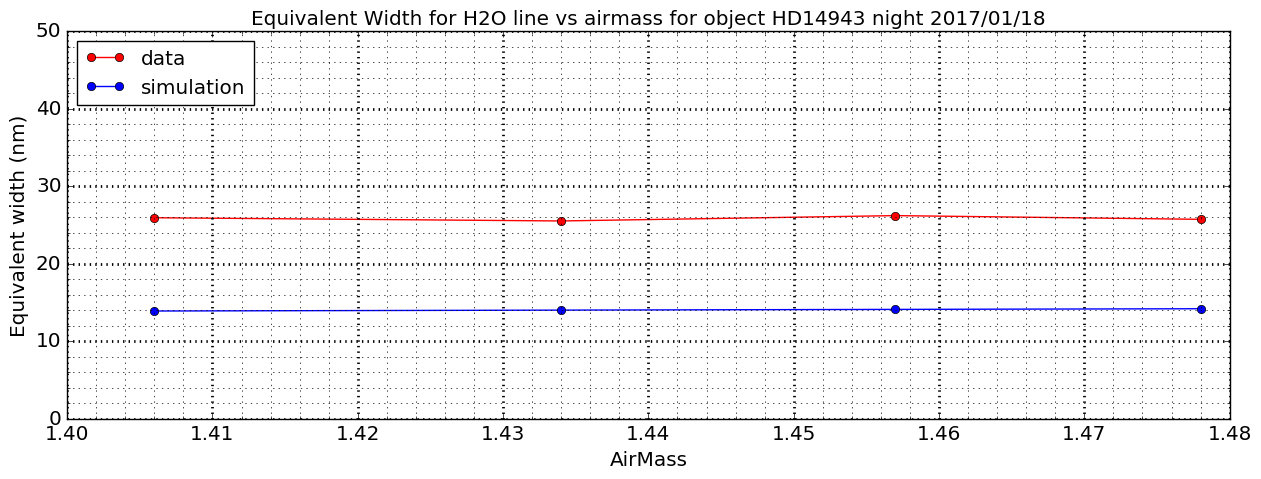

In [177]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)

ax.plot(am, All_eqw_H2O_Data,marker='o',color='red',lw=1,label='data')
ax.plot(am, All_eqw_H2O_Sim,marker='o',color='blue',lw=1,label='simulation')

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())   
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.set_ylabel('Equivalent width (nm)')
ax.set_xlabel('AirMass')

ax.set_ylim(0.,50.)

title='Equivalent Width for H2O line vs airmass for object {} night 2017/01/18'.format(object_name)

plt.title(title)
plt.legend(loc=2)

#plt.savefig(figfilename1, bbox_inches='tight')

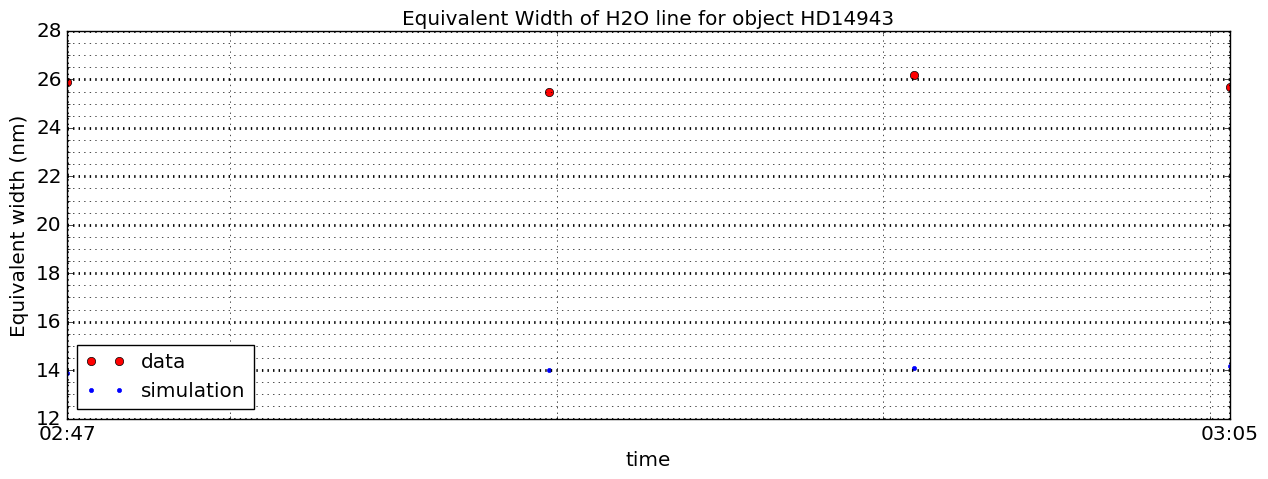

In [178]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, All_eqw_H2O_Data,marker='o',color='red',lw=0,label='data',linewidth=3)
ax.plot_date(all_dt, All_eqw_H2O_Sim,marker='.',color='blue',lw=0,label='simulation',linewidth=3)
#ax.plot_date(all_dt, am,marker='+',color='black',label='airmass',linewidth=3)
#ax.set_ylim(0,30.)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('Equivalent width (nm)')
ax.set_xlabel('time')


title='Equivalent Width of H2O line for object {}'.format(object_name)

plt.title(title)
plt.legend(loc=3)


## C) HBETA absorption line
===================================


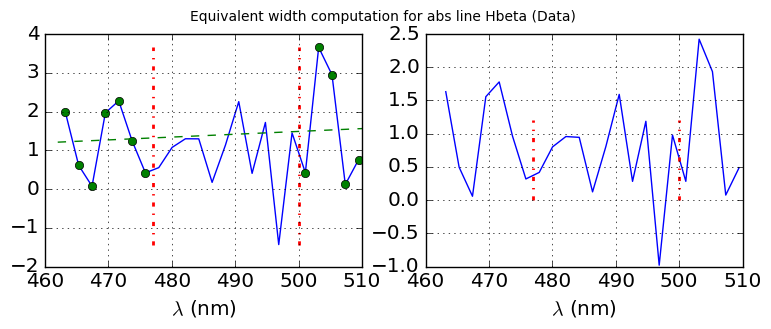

In [179]:
EQW_BETA_DATA = ShowEquivalentWidth2(thewl,thespectrum,462,477,500,510,'abs line Hbeta (Data)')

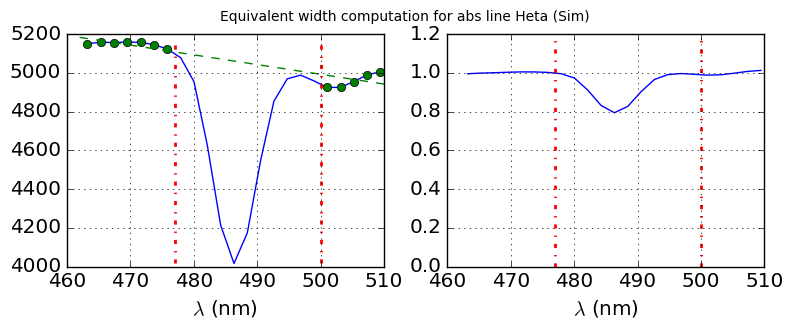

In [180]:
EQW_BETA_DATA = ShowEquivalentWidth2(thewl,thesimspectrum,462,477,500,510,'abs line Heta (Sim)')

In [181]:
WL1_HBETA_DATA=462
WL2_HBETA_DATA=477
WL3_HBETA_DATA=500
WL4_HBETA_DATA=510

In [182]:
WL1_HBETA_SIM=462
WL2_HBETA_SIM=477
WL3_HBETA_SIM=500
WL4_HBETA_SIM=510

In [183]:
All_eqw_HBETA_Data=ComputeAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_data,WL1_HBETA_DATA,WL2_HBETA_DATA,WL3_HBETA_DATA,WL4_HBETA_DATA)

In [184]:
All_eqw_HBETA_Sim=ComputeAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_sim,WL1_HBETA_SIM,WL2_HBETA_SIM,WL3_HBETA_SIM,WL4_HBETA_SIM)

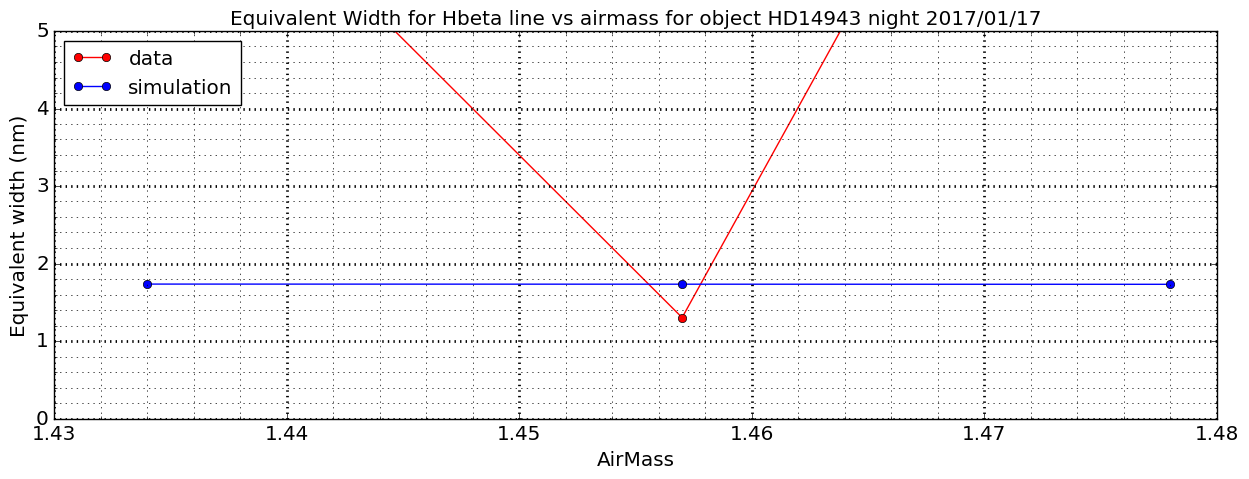

In [185]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)

ax.plot(am[1:], All_eqw_HBETA_Data[1:],marker='o',color='red',lw=1,label='data')
ax.plot(am[1:], All_eqw_HBETA_Sim[1:],marker='o',color='blue',lw=1,label='simulation')

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())   
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.set_ylabel('Equivalent width (nm)')
ax.set_xlabel('AirMass')

ax.set_ylim(0.,5.)

title='Equivalent Width for Hbeta line vs airmass for object {} night 2017/01/17'.format(object_name)

plt.title(title)
plt.legend(loc=2)

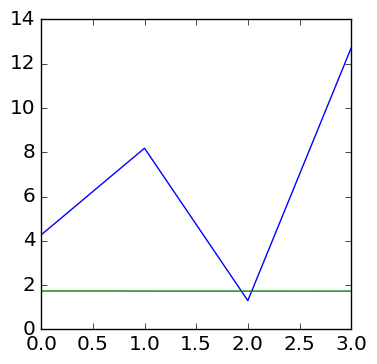

In [186]:
plt.plot(All_eqw_HBETA_Data)
plt.plot(All_eqw_HBETA_Sim)

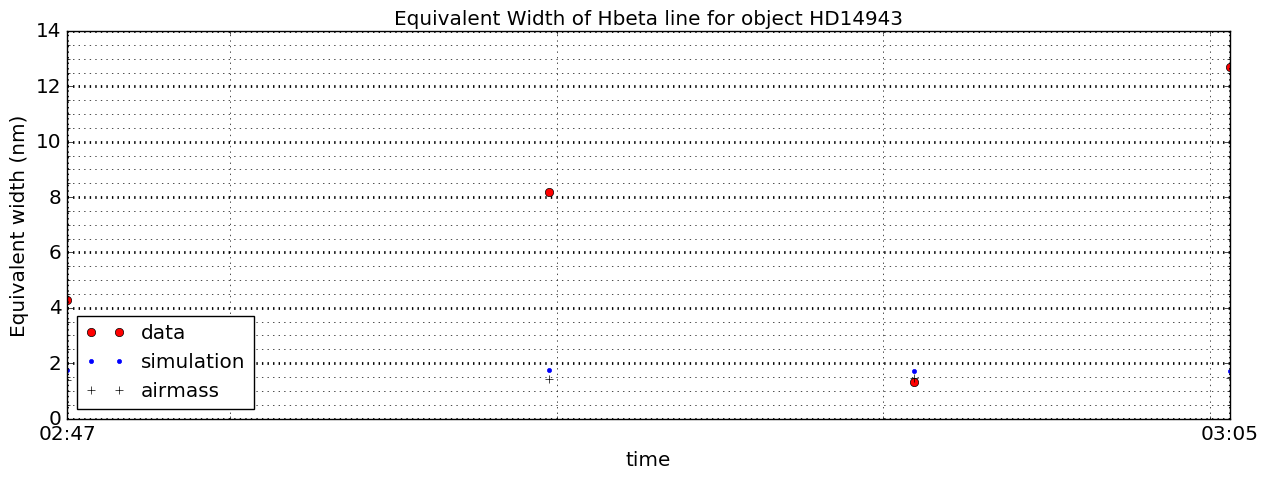

In [187]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, All_eqw_HBETA_Data,marker='o',color='red',lw=0,label='data',linewidth=3)
ax.plot_date(all_dt, All_eqw_HBETA_Sim,marker='.',color='blue',lw=0,label='simulation',linewidth=3)
ax.plot_date(all_dt, am,marker='+',color='black',label='airmass',linewidth=3)
#ax.set_ylim(0,1.2)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('Equivalent width (nm)')
ax.set_xlabel('time')


title='Equivalent Width of Hbeta line for object {}'.format(object_name)

plt.title(title)
plt.legend(loc=3)




## D) HALPHA absorption line
=======================================

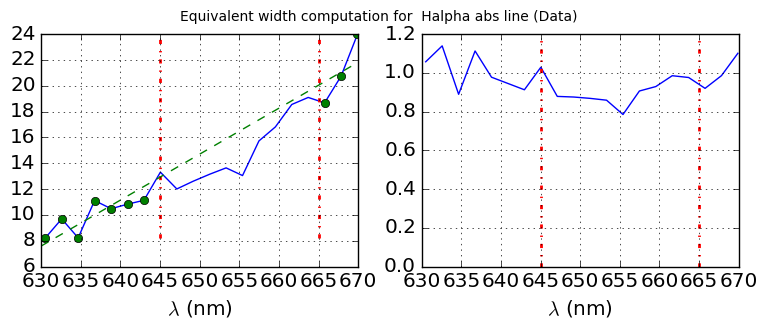

In [188]:
EQW_HALPHA_DATA = ShowEquivalentWidth2(thewl,thespectrum,630,645,665,670,' Halpha abs line (Data)') 

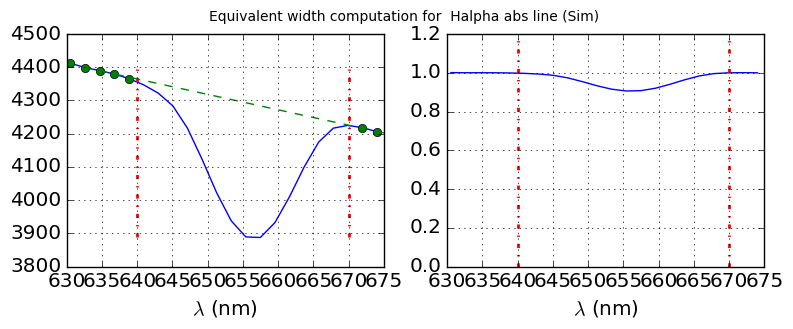

In [189]:
EQW_HALPHA_SIM = ShowEquivalentWidth2(thewl,thesimspectrum,630,640,670,675,' Halpha abs line (Sim)') 

In [190]:
WL1_HALPHA_DATA=630
WL2_HALPHA_DATA=645
WL3_HALPHA_DATA=665
WL4_HALPHA_DATA=670

In [191]:
WL1_HALPHA_SIM=630
WL2_HALPHA_SIM=640
WL3_HALPHA_SIM=670
WL4_HALPHA_SIM=675

In [192]:
All_eqw_HALPHA_Data=ComputeAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_data,WL1_HALPHA_DATA,WL2_HALPHA_DATA,WL3_HALPHA_DATA,WL4_HALPHA_DATA)

In [193]:
All_eqw_HALPHA_Sim=ComputeAllEquivalentWidth(all_rightspectra_wl,all_rightspectra_sim,WL1_HALPHA_SIM,WL2_HALPHA_SIM,WL3_HALPHA_SIM,WL4_HALPHA_SIM)

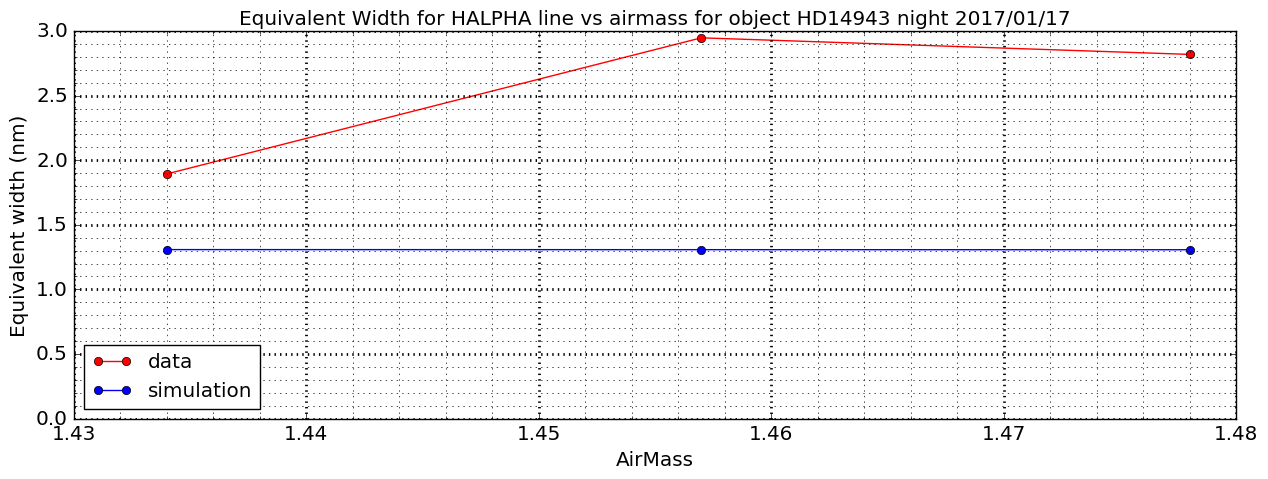

In [194]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)

ax.plot(am[1:], All_eqw_HALPHA_Data[1:],marker='o',color='red',lw=1,label='data')
ax.plot(am[1:], All_eqw_HALPHA_Sim[1:],marker='o',color='blue',lw=1,label='simulation')

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())   
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.set_ylabel('Equivalent width (nm)')
ax.set_xlabel('AirMass')

ax.set_ylim(0.,3.)

title='Equivalent Width for HALPHA line vs airmass for object {} night 2017/01/17'.format(object_name)
plt.legend(loc=3)
plt.title(title)

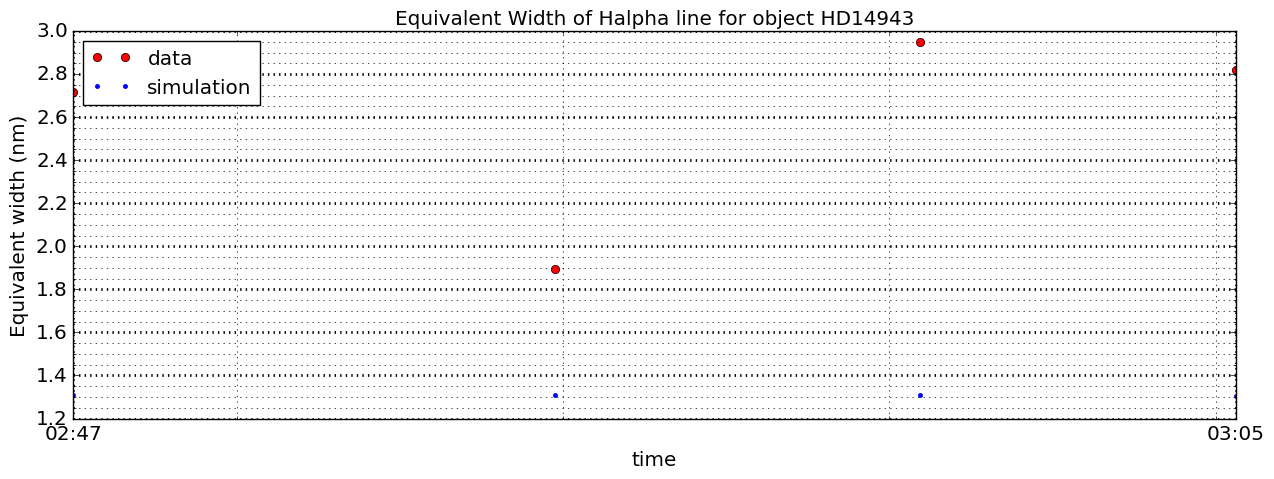

In [195]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, All_eqw_HALPHA_Data,marker='o',color='red',lw=0,label='data',linewidth=3)
ax.plot_date(all_dt, All_eqw_HALPHA_Sim,marker='.',color='blue',lw=0,label='simulation',linewidth=3)
#ax.plot_date(all_dt, am,marker='+',color='black',label='airmass',linewidth=3)
#ax.set_ylim(0,1.2)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('Equivalent width (nm)')
ax.set_xlabel('time')


title='Equivalent Width of Halpha line for object {}'.format(object_name)

plt.title(title)
plt.legend(loc=2)

